# <center>chap9.1 Clustering</center>
---

**<font color='red' size=4>clustering</font>** is an **unsupervised** task of identifying similar instances and assigning them to **clusters**, or groups of similar instances.

It's used in a wide variety of applications:

+ <font color='blue'>customer segmentation</font>

  You can cluster customers based on their purchases and their activity on your website, so you can adapt your products and marketing campaigns to each segment. E.g., customer segmentation can be useful in **recommender systems** to suggest content that other users in the same cluster enjoyed.


+ <font color='blue'>data analysis</font>

  It's helpful to run a clustering algorithm when analyzing a new data, and then analyze each cluster separately.
  

+ <font color='blue'>nonlinear dimensionality reduction</font>

  Once a dataset has been clustered, it is usually possible to measure each instance’s **<font color='red'>affinity</font>** with each cluster (affinity is any measure of how well an instance fits into a cluster). Each instance’s feature vector $X$ can then be replaced with the vector of its cluster affinities. If there are k clusters, then this vector is k-dimensional. This vector is typically much lower-dimensional than the original feature vector, but it can preserve enough information for further processing.


+ <font color='blue'>anomaly detection (outlier detection)</font>

  **Any instance that has a low affinity to all the clusters is likely to be an anomaly.**
  
  **Anomaly detection is particularly useful in detecting defects in manufacturing, or for fraud detection.**


+ <font color='blue'>semi-supervised learning</font>

  **If you only have a few labels, you could perform clustering and propagate the labels to all the instances in the same cluster.** This can greatly increase the number of labels available for a subsequent supervised learning algorithm, and thus improve its performance.


+ <font color='blue'>search engines</font>

  **Some search engines let you search for images that are similar to a reference image.**

  To build such a system, you would first apply a clustering algorithm to all the images in your database; similar images would end up in the same cluster. Then when a user provides a reference image, all you need to do is use the trained clustering model to find this image’s cluster, and you can then simply return all the images from this cluster.


+ <font color='blue'>image segmentation</font>

  **By clustering pixels according to their color, then replacing each pixel’s color with the mean color of its cluster**, it is possible to considerably reduce the number of different colors in the image. Image segmentation is used in many object detection and tracking systems, as it makes it easier to detect the contour of each object.

<font color='crimson'>There is no universal definition (统一的定义) of what a cluster is: it really depends on the context, and different algorithms will capture different kinds of clusters.</font>

- Some algorithms look for instances centered around a particular point, called a **<font color='red'>centroid</font>**.


- Others look for continuous regions of densely packed instances: these clusters can take on any shape.


- Some algorithms are hierarchical, looking for clusters of clusters. And the list goes on.

## 1. K-Means

> It's proposed by Stuart Lloyd at Bell Labs in 1957. In 1965, Edward W. Forgy had published virtually the same algorithm. So, K-Means is sometimes referred to as Lloyd-Forgy.

In [1]:
# Common imports
import os
import sys
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn

%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.random.seed(42)
# warnings.filterwarnings(action='ignore', message="^internal gelsd")

In [2]:
print('python version:', sys.version_info)
print('matplotlib version:', mpl.__version__)
print('numpy version:', np.__version__)
print('pandas version:', pd.__version__)
print('scikit-learn version:', sklearn.__version__)

python version: sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib version: 3.1.2
numpy version: 1.18.1
pandas version: 1.0.1
scikit-learn version: 0.22.1


In [3]:
from sklearn.datasets import make_blobs  # blob:一点/团

In [4]:
blob_centers = np.array([
    [0.2, 2.3],
    [-1.5, 2.3],
    [-2.8, 1.8],
    [-2.8, 2.8],
    [-2.8, 1.3],
])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std,
                  random_state=7)

In [5]:
y

array([4, 2, 0, ..., 3, 0, 2])

In [6]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel('$x_1$', fontsize=14)
    plt.ylabel('$x_2$', fontsize=14, rotation=0)

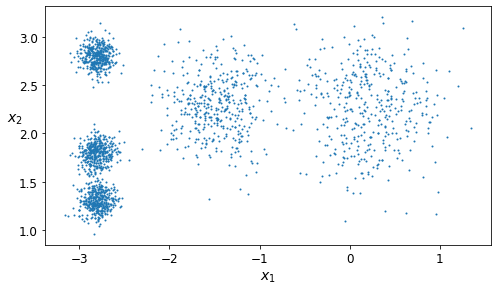

In [7]:
plt.figure(figsize=(8, 4.4))
# plot_clusters(X, y)
plot_clusters(X)
plt.show()

K-Means algorithm is a simple algorithm capable of clustering this kind of dataset very quickly and efficiently, often in just a few iterations.

In [8]:
from sklearn.cluster import KMeans

In [9]:
k = 5
# n_init: default=10
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
# Compute cluster centers and predict cluster index for each sample.
y_pred = kmeans.fit_predict(X)
y_pred

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

**<font color='crimson'>In the context of clustering, an instance’s label is the index of the cluster that this instance gets assigned to by the algorithm.</font>**

**The `KMeans` instance preserves a copy of the labels of the instances it was trained on, available via the `labels_` instance variable:**

In [10]:
# Labels of each point
kmeans.labels_

array([4, 1, 0, ..., 3, 0, 1], dtype=int32)

**<font color='blue'>In this context, the label of an instance is the index of the cluster that instance gets assigned to.</font>**

In [11]:
y_pred is kmeans.labels_

True

In [12]:
kmeans.labels_ is y

False

In [13]:
np.array_equal(y_pred, kmeans.labels_)

True

In [14]:
y

array([4, 2, 0, ..., 3, 0, 2])

> 原始数据集的 `y` 和原始数据集的 cluster index 形式不同，但内容一样。比如，这里原始数据集中的 `y==2` 和预测结果中/`kmeans.labels_` 中的 1 代表一个意思，表示同一个 cluster。

**`kmeans.cluster_centers_`**: Coordinates of cluster centers. If the algorithm stops before fully converging (see `tol` and `max_iter`), these will not be consistent with `labels_`.

In [15]:
# Look at the 5 centroids that the algorithm found
kmeans.cluster_centers_

array([[ 0.20876306,  2.25551336],
       [-2.80389616,  1.80117999],
       [-1.46679593,  2.28585348],
       [-2.79290307,  2.79641063],
       [-2.80037642,  1.30082566]])

In [16]:
# Assign new instances to the cluster whose centroid is closest
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 0, 3, 3], dtype=int32)

Plot the model's decision boundaries. This gives a **<font color='red'>Voronoi diagram</font>**.

In [17]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)


def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max()/10]
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=30,
                linewidths=8, color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=15,
                linewidths=50, color=cross_color, zorder=11, alpha=1)


def plot_decision_boundaries(clusterer, X, resolution=1000,
                             show_centroids=True, show_xlabels=True,
                             show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                 cmap='Pastel2')
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)

    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel('$x_1$', fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel('$x_2$', fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

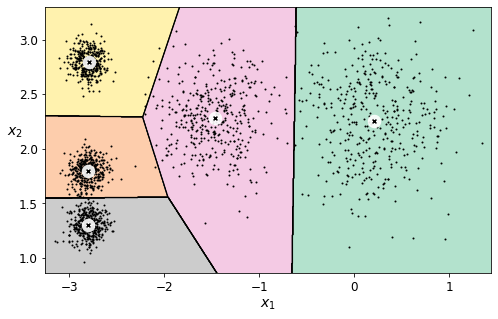

In [18]:
plt.figure(figsize=(8, 4.9))
plot_decision_boundaries(kmeans, X)
plt.show()

The vast majority of the instances were clearly assigned to the appropriate cluster, but a few instances were probably mislabeled (especially near the boundary between the top-left cluster and the central cluster).

**<font color='crimson'>Indeed, the K-Means algorithm does not behave very well when the blobs have very different diameters(直径) because all it cares about when assigning an instance to a cluster is the distance to the centroid.</font>**

## 2. Hard clustering *vs* Soft clustering (dimensionality reduction)

**<font color='red' size=3>hard clustering</font> assigns each instance to a single cluster**, while **<font color='red' size=3>soft clustering</font> gives each instance a score per cluster**. The score can be the distance between the instance and the centroid; conversely, it can be a similarity score (or affinity), such as the Gaussian Radial Basis Function.

**<font color='blue'>In `Kmeans` class, the `transform()` method measures the distance from each instance to every centroid.</font>**

In [19]:
kmeans.transform(X_new)

array([[0.32995317, 2.81093633, 1.49439034, 2.9042344 , 2.88633901],
       [2.80290755, 5.80730058, 4.4759332 , 5.84739223, 5.84236351],
       [3.29399768, 1.21475352, 1.69136631, 0.29040966, 1.71086031],
       [3.21806371, 0.72581411, 1.54808703, 0.36159148, 1.21567622]])

Here, the first instance in `X_new` is located at a distance of 0.33 from the 1st centroid, 2.81 from the the 2nd centroid, 1.49 from the 3rd centroid, 2.90 from the 4th centroid, and 2.89 from the 5th centroid.

If you have a high-dimensional dataset and you transform it this way, you end up with a k-dimensional dataset: **<font color='crimson'>this transformation can be a very efficient nonlinear dimensionality reduction technique</font>**.

## 3. The K-Means algorithm (the original algorithm)

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:

- First initialize k centroids randomly: k distinct instances are chosen randomly from the dataset and the centroids are placed at their locations. 


- Repeat until convergence (i.e., until the centroids stop moving):

  - Assign each instance to the closest centroid.
  
  - Update the centroids to be the mean of the instances that are assigned to them.


**The algorithm is guaranteed to converge in a finite number of steps (usually quite small); it will not oscillate** (震荡，来回摆动) **forever.**

The `KMeans` class applies an optimized algorithm by default. **<font color='blue'>To get the original K-Means algorithm (for educational purposes only)</font>, you must set `init='random'`, `n_init=1` and `algorithm='full'`**.

Run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [20]:
kmeans_iter1 = KMeans(n_clusters=5, init='random', n_init=1, algorithm='full',
                      max_iter=1, random_state=1)  # The original K-Means algorithm
kmeans_iter2 = KMeans(n_clusters=5, init='random', n_init=2, algorithm='full',
                      max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init='random', n_init=3, algorithm='full',
                      max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=5,
       n_init=3, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

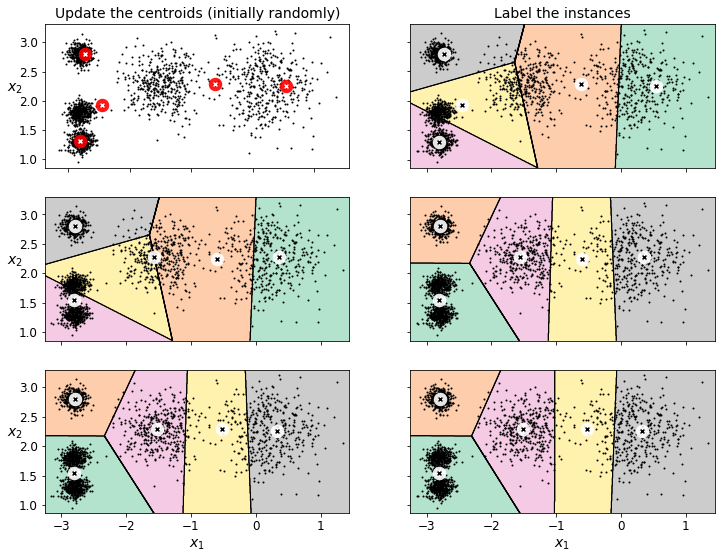

In [21]:
plt.figure(figsize=(12, 9))

# the centroids are initialized randomly
plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel('$x_2$', fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

# the instances are labeled
plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title('Label the instances', fontsize=14)

# the centroids are updated
plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

# the instances are relabeled
plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

# the centroids are updated
plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

# the instances are relabeled
plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

The centroids are just initialized randomly, and the algorithm simply runs a single iteration to gradually improve the centroids, as we saw above.

<div class="alert alert-block alert-info">
    <b><center>Note</center></b> <br>

The <b>computational complexity of the algorithm is generally linear</b> with regard to the number of instances m, the number of clusters k, and the number of dimensions n. However, this is <b>only true when the data has a clustering structure</b>. If it does not, then in the worst-case scenario the complexity can increase exponentially with the number of instances. In practice, this rarely happens, and K-Means is **generally one of the fastest clustering algorithms**.
</div>

## 4. K-Means Variability

**<font color='blue'>Although the algorithm is guaranteed to converge, it may not converge to the right solution (i.e., it may converge to a local optimum): whether it does or not depends on the centroid initialization.</font>**

**If you run K-Means multiple times (or with different random seeds), it can converge to very different solutions.**

In [22]:
def plot_clusterer_comparsion(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(12, 3.6))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)

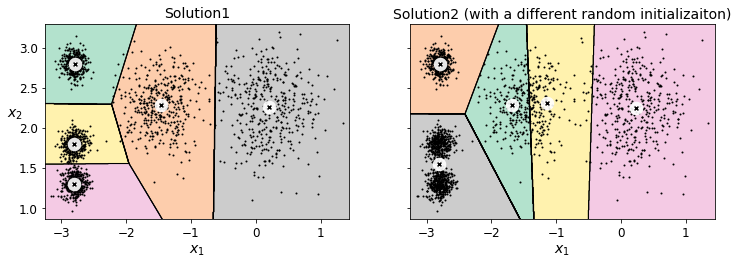

In [23]:
# The original kmeans
kmeans_rnd_init1 = KMeans(n_clusters=5, init='random', n_init=1,
                          algorithm='full', random_state=11)
kmeans_rnd_init2 = KMeans(n_clusters=5, init='random', n_init=1,
                          algorithm='full', random_state=10)

plot_clusterer_comparsion(kmeans_rnd_init1, kmeans_rnd_init2, X, 'Solution1',
                          'Solution2 (with a different random initializaiton)')
plt.show()

Next, look at a few ways you can mitigate this risk by improving the centroid initialization.

## 5. Centroid initialization methods

**<font color='crimson'>3 ways:</font>**
+ **Way 1**: `init`=ndarray of shape (n_clusters, n_features)


+ **Way 2**: `init='random'`


+ **Way 3**: `init='k-means++`

- **<font color='blueviolet'>Way 1: know approximately where the centroids should be</font>**

If you happen to know approximately where the centroids should be, you can set the `init` hyperparameter to a NumPy array containing the list of centroids, and set `n_init` to 1.

In [24]:
good_init = np.array([[-3, 3], [-3, 2], [-3, 1], [-1, 2], [0, 2]])
KMeans(n_clusters=5, init=good_init, n_init=1, random_state=42)

KMeans(algorithm='auto', copy_x=True,
       init=array([[-3,  3],
       [-3,  2],
       [-3,  1],
       [-1,  2],
       [ 0,  2]]),
       max_iter=300, n_clusters=5, n_init=1, n_jobs=None,
       precompute_distances='auto', random_state=42, tol=0.0001, verbose=0)

- **<font color='blueviolet'>Way 2: run the algorithm multiple times with different random initializations and keep the best solution</font>**

Run the algorithm multiple times with different random initialization and keep the best one.

The number of random initialization is controlled by the **`n_init`** (default=10) hyperparameter. The algorithm runs 10 `n_init` times when you call `fit()`, and sklearn keeps the best solution.

**Model's <font color='crimson'>inertia</font> (`kmeans.inertia_`) is used as a performance metric for K-Means, which is the mean squared distance between each instance and its closest centroid.**

The `KMeans` class runs the algorithm `n_init` times and keeps the model with the lowest inertia.

In [25]:
KMeans(n_clusters=5, init='random', n_init=5, random_state=42)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=5,
       n_init=5, n_jobs=None, precompute_distances='auto', random_state=42,
       tol=0.0001, verbose=0)

In [26]:
# Sum of squared distances of samples to their closest cluster center.
kmeans.inertia_

211.5985372581684

**The `score()` method returns the negative inertia.**

<div class="alert alert-block alert-danger">
    A predictor's `score()` method must always respect <b>Sklearn's "greater is better" rule</b>: if a predictor is better than another, its `score()` method should return a greater score.
</div>

In [27]:
kmeans.score(X)

-211.59853725816856

- **<font color='blueviolet'>Way 3: K-Means++</font>**

[K-Means++](https://homl.info/37) , proposed in 2006, **introduced a smarter initialization step that tends to select centroids that are distant from one another, and this improvement makes the K-Means algorithm much less likely to converge to a suboptimal solution.**

The additional computation required for the smarter initialization step is well worth it because it makes it possible to drastically reduce the number of times the algorithm needs to be run to find the optimal solution


**<font color='crimson'>K-Means++ initialization algorithm:</font>**

1. Take one centroid $c^1$, chosen uniformly at random from the dataset

2. Take a new centroid $c^i$, choosing an instance $x^i$ with probability ${D(x^i)}^2 / \sum^m_{j=1}{D(x^j)}^2$, where ${D(x^i)}$ is the distance between the instance $x^i$ and the closest centroid that was already chosen. This probability distribution ensures that instances farther away from already chosen centroids are much more likely be selected as centroids.

3. Repeat the previous step until all k centroids have been chosen.


**This initialization method is default in `Kmeans` class.**

In [28]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## 6. Accelerate K-Means

- **<font color='blueviolet'>Way 1: Elkan K-Means</font>**

[2003 paper by Charles Elkan](https://homl.info/38) considerably **accelerates the algorithm by avoiding many unnecessary distance calculation**. Elkan achieved this by **exploiting** (利用) **the triangle inequality (i.e., that a straight line is always the shortest distance between two points) and by keeping track of lower and upper bounds for distances between instances and centroids**.

**To use Elkan variant of K-Means, just set `algorithm='elkan'`.** It **does not support sparse data**. So by default, Sklearn uses `'elkan'` for dense data, and `'full'` (the regular K-Means algorithm) fro sparse data. 

In [29]:
KMeans()

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [30]:
# Elkan variant for K-Means
%timeit -n 50 KMeans(algorithm='elkan', random_state=42).fit(X)

56.2 ms ± 946 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [31]:
# The regular K-Means
%timeit -n 50 KMeans(algorithm='full', random_state=42).fit(X)

79.6 ms ± 923 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


- **<font color='blueviolet'>Way 2: Mini-batch K-Means</font>**

In [2010 paper by David Sculley](https://homl.info/39), instead of using the full dataset at each iteration, the algorithm is capable of **using mini-batches, moving the centroids just slightly at each iteration**.

**This speeds up the algorithm typically by a factor of three or four and makes it possible to cluster huge datasets that do not fit in memory.**

In [32]:
from sklearn.cluster import MiniBatchKMeans

In [33]:
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [34]:
minibatch_kmeans.inertia_

211.93186531476775

1. **<font color='crimson'>If the dataset does not fit in memory, the simplest option is to use the memmap class</font>** (as we did for incremental PCA in Chapter 8.) 


2. **Alternatively**, you can **pass one mini-batch at a time to the `partial_fit()` method**, but this will require much more work, since you will need to perform multiple initializations and select the best one yourself (see the mini-batch K-Means section of the notebook for an example).

In [35]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.int64)

x_train, x_test, y_train, y_test = train_test_split(
    mnist['data'], mnist['target'], random_state=42)
x_train.shape, x_test.shape

((52500, 784), (17500, 784))

In [36]:
# Use `np.memmap()` if the dataset does not fit in memory
filename = '../datasets/my_mnist_chap9.data'
x_mm = np.memmap(filename, dtype='float32', mode='write', shape=x_train.shape)
x_mm[:] = x_train

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, random_state=42)
minibatch_kmeans.fit(x_mm)

MiniBatchKMeans(batch_size=10, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

**If your data is so large that you cannot use `memmap`, things get more complicated.** Let's start by writing a function to load the next batch (in real life, you would load the data from disk):

In [37]:
def load_next_batch(batch_size, data=X):
    return data[np.random.choice(len(data), batch_size, replace=False)]

In [38]:
k = 5
n_init = 10
n_iterations = 100
batch_size = 100
init_size = 500  # more data for K-Means++ initialization
evaluate_on_last_n_iters = 10

best_kmeans = None

for init in range(n_init):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, init_size=init_size,
                                       random_state=42)
    x_init = load_next_batch(init_size)
    minibatch_kmeans.partial_fit(x_init)

    minibatch_kmeans.sum_inertia_ = 0
    for iteration in range(n_iterations):
        x_batch = load_next_batch(batch_size)
        minibatch_kmeans.partial_fit(x_batch)
        if iteration >= n_iterations-evaluate_on_last_n_iters:
            minibatch_kmeans.sum_inertia_ += minibatch_kmeans.inertia_

    if (best_kmeans is None or
        minibatch_kmeans.sum_inertia_ < best_kmeans.sum_inertia_):
        best_kmeans = minibatch_kmeans

In [39]:
best_kmeans.score(X)

-211.69840901859536

In [40]:
best_kmeans.inertia_  # 🤔

12.017759887238839

In [41]:
best_kmeans.sum_inertia_  # 🤔

101.5380140190461

**Mini-batch K-Means is much faster than regular K-Means:**

In [42]:
# regular K-Means
%timeit KMeans(n_clusters=5, random_state=42).fit(X)

30.2 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
# Mini-batch K-Means
%timeit MiniBatchKMeans(n_clusters=5, random_state=42).fit(X)

17 ms ± 849 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


**<font color='crimson'>Although the Mini-batch K-Means algorithm is much faster than the regular K-Means algorithm, its inertia is generally slightly worse, especially as the number of clusters increases.</font>**

In [44]:
from timeit import timeit

In [45]:
times = np.empty((100, 2))
inertias = np.empty((100, 2))

for k in range(1, 101):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k-1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k-1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k-1, 0] = kmeans_.inertia_
    inertias[k-1, 1] = minibatch_kmeans.inertia_

100/100

> **`print("\r{}/{}".format(k, 100), end="")`**

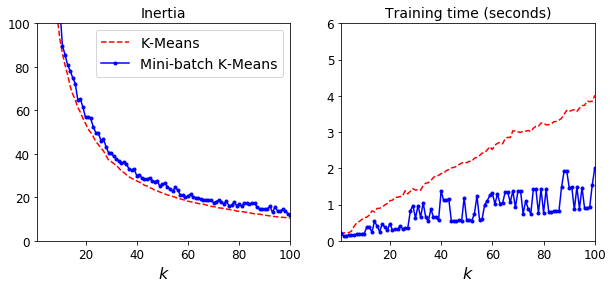

In [46]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, 101), inertias[:, 0], 'r--', label='K-Means')
plt.plot(range(1, 101), inertias[:, 1], 'b.-', label='Mini-batch K-Means')
plt.xlabel('$k$', fontsize=16)
plt.title('Inertia', fontsize=14)
plt.legend(fontsize=14)
plt.axis([1, 100, 0, 100])

plt.subplot(122)
plt.plot(range(1, 101), times[:, 0], "r--", label='K-Means')
plt.plot(range(1, 101), times[:, 1], "b.-", label='Mini-batch K-Means')
plt.xlabel('$k$', fontsize=16)
plt.title('Training time (seconds)', fontsize=14)
plt.axis([1, 100, 0, 6])

plt.show()

> + (left plot) The difference between the two curves remains fairly constant, but this difference becomes more and more significant as k increases, since the inertia becomes smaller and smaller.
> + (right plot) Mini-batch K-Means is much faster than regular K-Means, and this difference increases with k.

## 7. Find the optimal number of clusters

**<font color='crimson'>The inertia is not a good performance metric when trying to choose k because it keeps getting lower as we increase k. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be.</font>**

- **<font color='blueviolet'>Way 1: elbow method</font>**

**This technique for choosing the best value for k is rather coarse.**

In [47]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
inertias

[3534.8360871670784,
 1149.6140723750277,
 653.2167190021553,
 261.79677785694696,
 211.5985372581684,
 169.2556273906365,
 141.38336489568496,
 118.41983763508077,
 102.52962740703077]

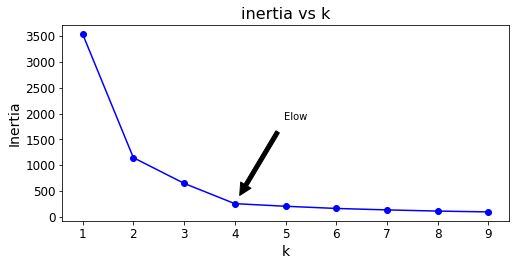

In [48]:
plt.figure(figsize=(8, 3.6))
plt.plot(range(1, 10), inertias, 'bo-')
plt.xlabel('k', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.annotate('Elow',  # The text of the annotation
             xy=(4, inertias[3]),  # The point (x,y) to annotate.
             xytext=(0.55, 0.55),
             textcoords='figure fraction',  # 0,0 是图形左下角，1,1 是右上角
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.xticks(range(1, 10))
plt.title('inertia vs k', fontsize=16)
plt.show()

The inertia drops very quickly when k=4, but then it decreases much more slowly as the k keeps increasing. This curve has roughly (大致地) the shape of an arm, and there is an "elbow" at k=4.

If we don't know better, k=4 would be a good choice: any lower value would be dramatic (巨大的), while any higher value would not help much, and we might just be splitting perfectly good clusters in half for no good reason.

<function matplotlib.pyplot.show(*args, **kw)>

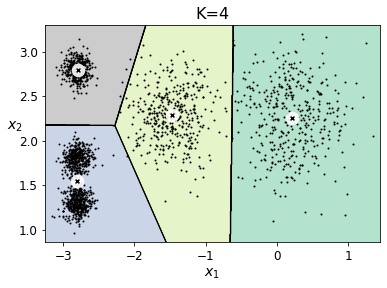

In [49]:
plot_decision_boundaries(kmeans_per_k[4-1], X)
plt.title('K=4', fontsize=16)
plt.show

- **<font color='blueviolet'>Way 2: silhouette score</font>**

A more precious approach (but also more computationlly expensive) is to use the **<font color='red'>silhouette score</font>**, which is **the mean silhouette coefficient over all the instances**.

The Silhouette Coefficient is **a measure of how well samples are clustered with samples that are similar to themselves. Clustering models with a high Silhouette Coefficient are said to be dense, where samples in the same cluster are similar to each other, and well separated, where samples in different clusters are not very similar to each other.**

**An instance's silhouette coefficient is equal to `(b - a) / max(a, b)`**, where `a` is the mean distance to the other instances in the same cluster (i.e., the mean intra-cluster distance) and `b` is the mean nearest-cluster distance (i.e., the mean distance to the instances of the next closest cluster, defined as the one that minimizes `b`, excluding the instance's own cluster).

**The silhouette coefficient can vary between -1 and +1.** A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to -1 means that the instance may have been assigned to the wrong cluster, and finally a coefficient close to 0 means that it is close to a cluster boundary.

**<font color='blue'>Note that Silhouette Coefficient is only defined if number of labels is 2 <= n_labels <= n_samples - 1.</font>**

In [50]:
from sklearn.metrics import silhouette_score

In [51]:
kmeans.inertia_

211.5985372581684

In [52]:
kmeans.score(X)

-211.59853725816856

In [53]:
silhouette_score(X, kmeans.labels_)

0.655517642572828

In [54]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]
silhouette_scores

[0.5966442557582528,
 0.5723900247411775,
 0.688531617595759,
 0.655517642572828,
 0.6020248775444942,
 0.6068660656395705,
 0.5616191906117943,
 0.5674347733914683]

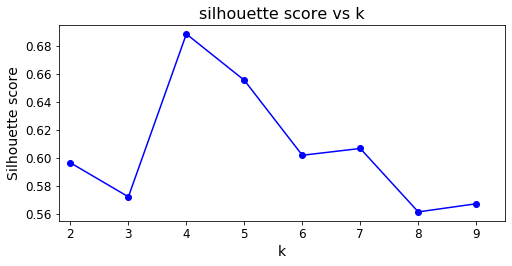

In [55]:
plt.figure(figsize=(8, 3.6))
plt.plot(range(2, 10), silhouette_scores, 'bo-')
plt.xlabel('k', fontsize=14)
plt.ylabel('Silhouette score', fontsize=14)
plt.xlim(1.8, 9.5)
plt.title('silhouette score vs k', fontsize=16)
plt.show()

This visualization is much richer than the previous one: although it confirms that k=4 is a very good choice, it also underlines the fact that k=5 is quite good as well, and much better than k=6/7. This is not visible when comparing inertias.

- **<font color='blueviolet'>Way 3: silhouette diagram</font>**

**<font color='red'>silhouette diagram</font>**, a even more informative visualization, **plots every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient.**

Each diagram contains one knife shape per cluster. The **shape's height** indicates the number of instances the cluster contains, and its **width** represents the sorted silhouette coefficients of the instances in the cluster (wider is better). The **vertical red dashed line** indicates the mean silhouette coefficient.

In [56]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [57]:
def plot_silhouette_diagram(X, n_clusters: list):
    for n_cluster in n_clusters:
        plt.figure(figsize=(12, 3.8))

        cluster = KMeans(n_clusters=n_cluster, random_state=42)
        cluster_labels = cluster.fit_predict(X)

        # Compute the silhouette scores
        silhouetter_avg = silhouette_score(X, cluster_labels)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        min_silhouette_value = sample_silhouette_values.min()

        # The 1st subplot is the silhouette plot
        plt.subplot(1, 2, 1)
        y_lower = 10
        for i in range(n_cluster):
            ith_cluster_silhouette_valus = sample_silhouette_values[
                cluster_labels == i]
            ith_cluster_silhouette_valus.sort()

            size_cluster_i = ith_cluster_silhouette_valus.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.Spectral(i / n_cluster)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0,
                              ith_cluster_silhouette_valus,
                              facecolor=color,
                              edgecolor=color,
                              alpha=0.7)
            # Label the silhouette plots with their cluster numbers at the middle
            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=14)

            # Compute the new `y_lower` for the next plot
            y_lower = y_upper + 40

        plt.axvline(x=silhouetter_avg, color='r', linestyle='--')
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.xlabel("The silhouette coefficient values", fontsize=12)
        plt.ylabel("Cluster label", fontsize=12)
        plt.xlim(min_silhouette_value, 1)
        plt.yticks([])  # Clear the y-axis labels/ticks
            

        # 2nd plot shows the actual clueters formed
        plt.subplot(1, 2, 2)
        plot_decision_boundaries(cluster, X)

        plt.suptitle("Silhouette analysis for KMeans clustering on sample "
                     "data with cluster={}".format(n_cluster), fontsize=16)
        plt.show()

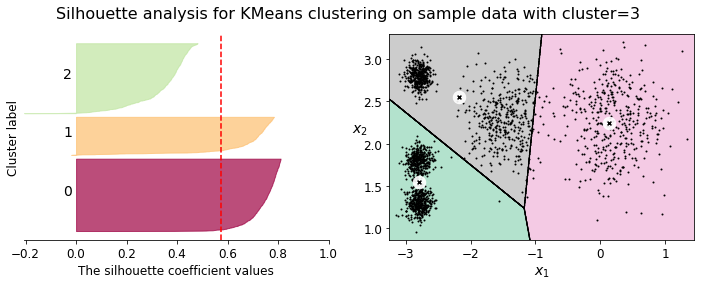

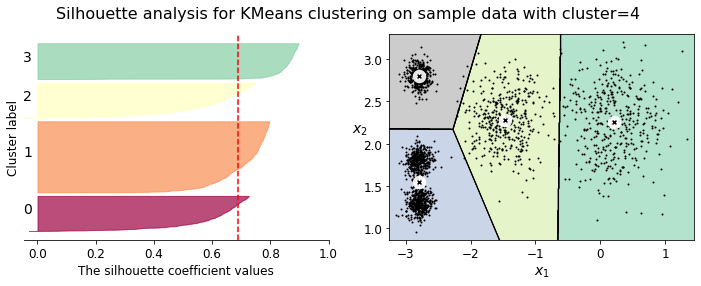

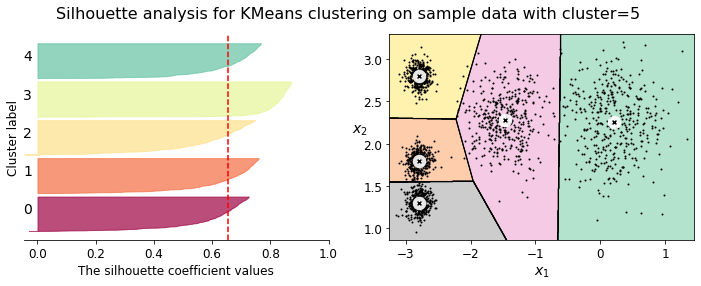

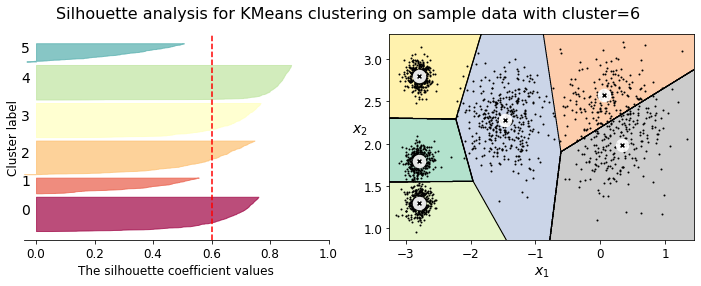

In [58]:
plot_silhouette_diagram(X, [3, 4, 5, 6])

The vertical red dashed lines represent the silhouette score for each number of clusters. When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters.

**<font color='cirmson'>(Why 5, not 4?)**</font> We can see that when k=3 and when k=6, we get bad clusters. But when k=4 or k=5, the clusters look pretty good: most instances extend beyond the dashed line, to the right and closer to 1.0. **When k = 4, the cluster at index 1 (the third from the top) is rather big. When k = 5, all clusters have similar sizes.** So, even though the overall silhouette score from k = 4 is slightly greater than for k = 5, it seems like a good idea to use k = 5 to get clusters of similar sizes.

## 8. Limits of K-Means

**Despite its many merits (优点), most notably being fast and scalable, K-Means is not prefect.**

- it's necessary to run several times to avoid suboptimal solutions;


- it's necessary to specify the number of clusters, which can be quite a hassle (麻烦，困难);


- K-Means does not behave very well when the clusters having varying sizes, different densities, or non-spherical (非球形/状的) shapes.

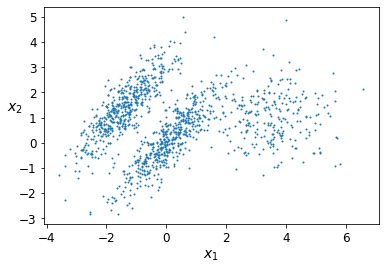

In [59]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_clusters(X)

In [60]:
kmeans1 = KMeans(n_clusters=3, init=np.array([[-1.5, 2.5], [0.5, 0], [4, 0]]),
                 n_init=1, random_state=42)
kmeans2 = KMeans(n_clusters=3, random_state=42)

kmeans1.fit(X)
kmeans2.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

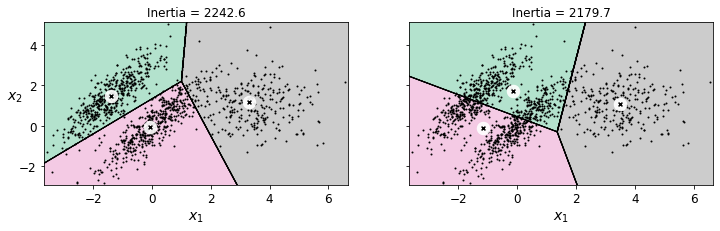

In [61]:
plt.figure(figsize=(12, 3))

plt.subplot(121)
plot_decision_boundaries(kmeans1, X)
plt.title("Inertia = {:.1f}".format(kmeans1.inertia_))

plt.subplot(122)
plot_decision_boundaries(kmeans2, X, show_ylabels=False)
plt.title("Inertia = {:.1f}".format(kmeans2.inertia_))

plt.show()

Neither of these solutions is any good. The solution on the left is better, but it still chops off 25% of the middle cluster and assigns it the cluster on the right. The right solution is just terrible, even though its inertia is lower.

So, **<font color='crimson'>depending on the data, different clustering algorithms may perform better. On these types of elliptical (椭圆形的) clusters, Gaussian mixture models work great<font>**.

<div class="alert alert-block alert-info">
    <center><b>Note</b></center><br>

It is important to **scale the input features before you run K-Means**, or the clusters may be very stretched(拉伸的，延伸的) and K-Means will perform poorly. Scaling the features does not guarantee that all the clusters will be nice and spherical(球形/状的), but it generally improves things.
</div>

## 9. Use clustering for image segmentation

**<font color='red'>Image segmentation</font>** is the task of partitioning  an image into multiple segments.

- **<font color='red'>semantic segmentation</font>**: all pixels that are part of the same object type get assigned to the same segment.

> <font color='blue'>Example:</font> In a self-driving car's vision system, all pixels that are part of a pedestrian's (行人) image might be assigned to the "pedestrian" segment (there would be one segment containing all the pedestrians).

- **<font color='red'>instance segmentation</font>**: all pixels that are part of the same individual object are assigned to the same segment.

> <font color='blue'>Example:</font> Here, there would be a different segment for each pedestrian.

**The SOTA in semantic or instance segmentation today is achieved using complex architectures based on CNN.**

<br>

Here, we do **color segmentation**. We will simply assign pixels to the same segment if they have a similar color.

In [62]:
import urllib

# Download image for an URL
image_path = "../figs/chap09-figs/"
filename = "ladybug.png"
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(image_path, filename))

('../figs/chap09-figs/ladybug.png', <http.client.HTTPMessage at 0x122ad1438>)

![figure](../figs/chap09-figs/ladybug.png)

In [63]:
from matplotlib.image import imread  # or `from imageio import imread`

# Load the image
image = imread(os.path.join(image_path, filename))
image.shape

(533, 800, 3)

In [64]:
image.max(), image.min()

(1.0, 0.0)

- The 1st dimension's size is the height;


- The 2nd is width;


- The 3rd is the number of color channels, in this case red, green, and blue (RGB).

**For each pixel there is a 3D vector containing the intensities of red, green, and blue, each between 0.0 and 1.0 (or between 0 and 255 by using `imageio.imread()`)**.

- Some images may have **fewer channels**, such as grayscale images (one channel).


- Some images may have **more channels**, such as images with an additional *alpha channel* for transparency(透明度) or satellite images, which often contain channels for many light frequencies (e.g., infrared). 

In [65]:
a = np.arange(8).reshape(2, 2, 2)
a

array([[[0, 1],
        [2, 3]],

       [[4, 5],
        [6, 7]]])

In [66]:
a.reshape(-1, 2)

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7]])

In [67]:
# Reshape the array to get a long list of RGB colors
X = image.reshape(-1, 3)
# Clusters these colors using K-Means
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)

In [68]:
kmeans.labels_

array([1, 1, 1, ..., 7, 7, 1], dtype=int32)

In [69]:
len(kmeans.labels_)

426400

In [70]:
kmeans.cluster_centers_

array([[0.61432445, 0.38323954, 0.09124164],
       [0.02091756, 0.10598001, 0.00559016],
       [0.98388034, 0.9394446 , 0.02598792],
       [0.20647109, 0.3730199 , 0.05209464],
       [0.60520667, 0.633312  , 0.39155474],
       [0.8982942 , 0.738117  , 0.03237016],
       [0.34292173, 0.52357715, 0.1520879 ],
       [0.09118783, 0.24308221, 0.01513819]], dtype=float32)

In [71]:
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

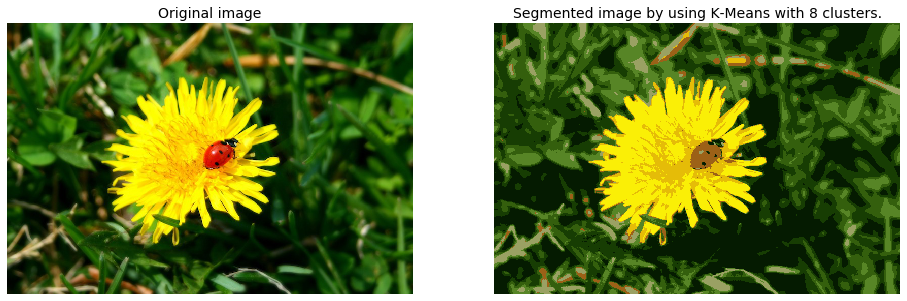

In [72]:
plt.figure(figsize=(16, 6))

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title("Original image", fontsize=14)

plt.subplot(122)
plt.imshow(segmented_img)
plt.axis('off')
plt.title("Segmented image by using K-Means with 8 clusters.", fontsize=14)

plt.show()

For example, it may identify a color cluster for all shades of green. Next, for each color (e.g., dark green), it looks for the mean color of the pixel’s color cluster. For example, all shades of green may be replaced with the same light green color (assuming the mean color of the green cluster is light green). Finally, it reshapes this long list of colors to get the same shape as the original image. And we’re done!

In [73]:
segmented_imgs = []
n_colors = [10, 8, 6, 4, 2]

for n_cluster in n_colors:
    kmeans = KMeans(n_clusters=n_cluster, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

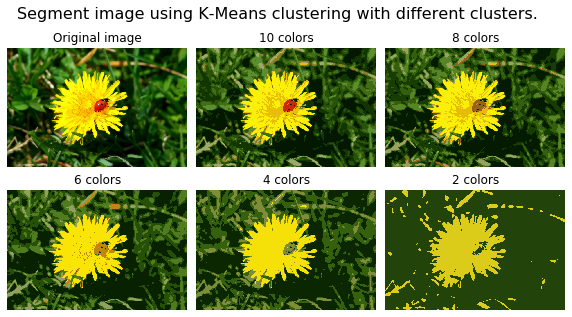

In [74]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.axis('off')
plt.title("Original image")

for idx, n_cluster in enumerate(n_colors):
    plt.subplot(232+idx)
    plt.imshow(segmented_imgs[idx])
    plt.axis('off')
    plt.title("{} colors".format(n_cluster))

plt.suptitle("Segment image using K-Means clustering with different clusters.",
             fontsize=16)
plt.show()

When you use fewer than 8 clusters, notice that the ladybug’s (瓢虫) flashy (显眼的) red color fails to get a cluster of its own: it gets merged with colors from the environment. This is because **K-Means prefers clusters of similar sizes**. The ladybug is small — much smaller than the rest of the image — so even though its color is flashy, K-Means fails to dedicate a cluster to it.

## 10. Use clustering for prepreocessing 

Clustering can be an efficient approach to dimensionality reduction, in particular as a preprocessing step before a supervised learning algorithm.

In [75]:
from sklearn.datasets import load_digits

x, y = load_digits(return_X_y=True)
x.shape, y.shape

((1797, 64), (1797,))

In [76]:
from sklearn.model_selection import train_test_split

In [77]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)
x_train.shape, x_test.shape

((1347, 64), (450, 64))

In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000,
                             random_state=42)
log_reg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=5000,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [80]:
log_reg.score(x_test, y_test)

0.9688888888888889

This is our baseline: 96.9%.

In [81]:
from sklearn.pipeline import Pipeline

In [82]:
# Use K-Means as a preprocessing step
pipeline = Pipeline([
    # Cluster the training set into 50 clusters, and replace the images
    # with their distances to these 50 clusters
    ('kmeans', KMeans(n_clusters=50, random_state=42)),
    # Apply a Logisitc Regression model
    ('log_reg', LogisticRegression(multi_class='ovr', solver='lbfgs',
                                   max_iter=5000, random_state=42)),
])
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('kmeans',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=50, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=42,
                        tol=0.0001, verbose=0)),
                ('log_reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=5000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

**<font color='crimson'>Since there are 10 different digits, it's tempting to set the number of clusters to 10. However, each digit can be written several different ways, so it's preferable to use a larger number of clusters, such as 50.</font>**

In [83]:
pipeline.score(x_test, y_test)

0.98

In [84]:
((1 - 0.96888) - (1 - 0.98)) / (1 - 0.96888)

0.35732647814910046

It reduced the error rate by over 35%.

Here, we chose the number of clusters k arbitrarily. Since K-Means is just a preprocessing step in a classification pipeline, finding a good value for k is much simpler than earlier. There’s no need to perform silhouette analysis or minimize the inertia; the best value of k is simply the one that results in the best classification performance during cross-validation. 

In [85]:
from sklearn.model_selection import GridSearchCV

In [86]:
# Use grid search to find the best value for k
param_grid = {'kmeans__n_clusters': range(2, 100)}
grid_clf = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1,
                        verbose=0)
grid_clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kmeans',
                                        KMeans(algorithm='auto', copy_x=True,
                                               init='k-means++', max_iter=300,
                                               n_clusters=50, n_init=10,
                                               n_jobs=None,
                                               precompute_distances='auto',
                                               random_state=42, tol=0.0001,
                                               verbose=0)),
                                       ('log_reg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                      

> Use `pipeline.get_params().keys()` to find estimator's parameters.

In [87]:
grid_clf.best_params_

{'kmeans__n_clusters': 96}

In [88]:
grid_clf.best_score_

0.9762357152691725

Why?? 书上k=99,score=0.98222.

## 11. Use clustering for semi-supervised learning

In [89]:
# Train a log-reg on a sample of 50 labeled instances from the digits dataset
n_labeled = 50
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', random_state=42)
log_reg.fit(x_train[:n_labeled], y_train[:n_labeled])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
log_reg.score(x_test, y_test)

0.8333333333333334

- **<font color='blueviolet'>Way 1: use representative x after K-Means</font>**

  - 1st, cluster the training set into 50 clusters.
  
  - 2nd, for each cluster, find the image closest to the centroid. These images are called <font color='red'>representative images</font>.
  
  - 3rd, label the representative images.
  
  - Finally, use these labeled representative images to train a model.**

In [91]:
# 1st, cluster the training set to 50 clusters
k = 50
kmeans = KMeans(n_clusters=50, random_state=42)
# Compute clustering and transform `X` to cluster-distance space.
x_digits_dist = kmeans.fit_transform(x_train)
x_digits_dist.shape

(1347, 50)

In [92]:
# 2nd, find the image closest to the centroid
representative_digit_idx = np.argmin(x_digits_dist, axis=0)  # shape: (50,)
x_representative_digits = x_train[representative_digit_idx]

In [93]:
# Labels of each point
np.argmin(x_digits_dist, axis=1)

array([13, 14, 26, ..., 39,  4, 10])

In [94]:
# Labels of each point
kmeans.labels_

array([13, 14, 26, ..., 39,  4, 10], dtype=int32)

In [95]:
# Labels of each point
kmeans.predict(x_train)

array([13, 14, 26, ..., 39,  4, 10], dtype=int32)

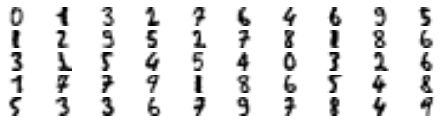

In [96]:
plt.figure(figsize=(8, 2))
for idx, x_representative_digit in enumerate(x_representative_digits):
    plt.subplot(k // 10, 10, idx+1)
    plt.imshow(x_representative_digit.reshape(8, 8), cmap='binary',
               interpolation='bilinear')
    plt.axis('off')
plt.show()

In [97]:
# 3rd, label each representative image manually
y_representative_digits = np.array([
    0, 1, 3, 2, 7, 6, 4, 6, 9, 5,
    1, 2, 9, 5, 2, 7, 8, 1, 8, 6,
    3, 1, 5, 4, 5, 4, 0, 3, 2, 6,
    1, 4, 7, 9, 1, 8, 6, 5, 4, 8,
    5, 3, 3, 6, 7, 9, 7, 8, 4, 9
])

> 和书上不一样。

Now, there is a dataset with just 50 labeled instances, but instead of being random instances, each of them is a representative image of its cluster.

In [98]:
# 4th, use these representative images to train a model
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000,
                             random_state=42)
log_reg.fit(x_representative_digits, y_representative_digits)
log_reg.score(x_test, y_test)

0.92

From 83.3% to 92% by still only training the model on 50 instances.

**This is a good idea to label representative instances rather than just random isntances.**

- **<font color='blueviolet'>Way 2: use label propagation after K-Means</font>**

**Propagate the labels to all the other instances in the same cluster.**

In [99]:
# Propagate the labels to all the othr instances in the same cluster
y_train_propagated = np.empty(len(x_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

In [100]:
# train a model after label propagation
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000,
                             random_state=42)
log_reg.fit(x_train, y_train_propagated)
log_reg.score(x_test, y_test)

0.9222222222222223

We got a reasonable accuracy boost, but nothing absolutely astounding (令人震惊的). The **<font color='blue'>problem</font>** is that we propagated each representative instance’s label to all the instances in the same cluster, including the instances located close to the cluster boundaries, which are more likely to be mislabeled

- **<font color='blueviolet'>Way 2: only propagate the labels to the 20% of the instances that are closest to the centroids</font>**

In [104]:
percentile_closest = 20

# x 到其对应 centroid 的距离
x_cluster_dist = x_digits_dist[np.arange(len(x_train)), kmeans.labels_]

for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    # 该 cluster 内所有点到该 cluster centroid 的距离
    cluster_dist = x_cluster_dist[in_cluster]
    # Compute the 20-th percentile of the cluster_dist
    cutoff_dist = np.percentile(cluster_dist, percentile_closest)  # a single value
    above_cutoff = (x_cluster_dist > cutoff_dist)
    x_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (x_cluster_dist != -1)
x_train_partially_propagated = x_train[partially_propagated]
# Use the propagated labels
y_train_partially_propagated = y_train_propagated[partially_propagated]

x_train_partially_propagated.shape

(289, 64)

In [108]:
log_reg = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=5000,
                             random_state=42)
log_reg.fit(x_train_partially_propagated, y_train_partially_propagated)
log_reg.score(x_test, y_test)

0.9133333333333333

> Sad! 书上应该是提高了，但我这里居然降低了。

We got 91.3% acc with just 50 labeled instances (only 5 examples per class on average), while we got 96.9% on fully labeled digits dataset.


**This good performance is due to the fact that the propagated labels are actually pretty good.**

In [109]:
np.mean(y_train_partially_propagated == y_train[partially_propagated])

0.9792387543252595

> 和书上不一样。

<div class="alert alert-block alert-info">
    <center><b><font color='red' size=4>Active Learning</font></b></center><br>
 
The next step to continue to improving the model and the training set could be to do a few rounds of <b><font color='red'>active learning</font></b>, which is when a human expert interacts with the learning algorithm, providing labels for specific instances when the algorithm requests them.
    
One of the **most common strategies** is called <b><font color='red'>uncertainty sampling</font></b>. Here is how it works:

1. The model is trained on the labeled instances gathered so far, and this model is used to make predictions on the all unlabeled instances.

2. The instances for which the model is most uncertain (i.e., its estimated probability is lowest) are given to the expert to be labeled.

3. Iterate this process until the performance improvement stops being worth the labeling effort.

**Other strategies:**
 
 - label the instances that would result in the largest model change
 
 - label the instances that would result in the largest drop in the model's validation error
 
 - label the instances that different models disagree on (e.g., an SVM or a RF)
</div>

## 12. DBSCAN

It's another popular clustering algorithm that illustrates a very different approach **based on local density estimation**, which allows the algorithm to **identify clusters of arbitrary shapes**.

Here is how it works:

- For each instance, the algorithm counts how many instances are located within a small distance ε (epsilon) from it. This region is called the instance’s **<font color='red'>ε-neighborhood</font>**.


- If an instance has at least **min_samples** instances in its ε-neighborhood (including itself), then it is considered a **<font color='red'>core instance</font>**. In other words, **core instances are those that are located in dense regions**.


- All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster. **Any core sample is part of a cluster.**


- **Any sample that is not a core sample, and is at least `eps` in distance from any core sample, is considered an outlier/anomaly by the algorithm.**


**<font color='blue'>This algorithm works well if all the clusters are dense enough and if they are well separated by low-density regions. (The DBSCAN algorithm views clusters as areas of high density separated by areas of low density.)</font>**  Due to this rather generic view, **clusters found by DBSCAN can be any shape**, as opposed to **K-Means** which assumes that **clusters are convex shaped**.

In [110]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

In [111]:
x, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(x)

DBSCAN(algorithm='auto', eps=0.05, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [113]:
# luster labels for each point in the dataset given to `fit()`
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

**<font color='crimson'>Noisy samples are given the label -1.</font>**

In [116]:
# Indices of core samples
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [117]:
len(dbscan.core_sample_indices_)

808

In [118]:
# Copy of each core sample found by training.
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

In [119]:
dbscan.components_.shape

(808, 2)

There are two parameters to the algorithm, `min_samples` and `eps`. **Higher `min_samples` or lower `eps` indicate higher density necessary to form a cluster.**

In [120]:
dbscan2 = DBSCAN(eps=0.2, min_samples=5)  # a higher eps
dbscan2.fit(x)

DBSCAN(algorithm='auto', eps=0.2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [121]:
def plot_dbscan(dbscan, x, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True   # core samples indices
    anomalies_mask = dbscan.labels_ == -1           # outliers indices
    non_core_mask = ~(core_mask | anomalies_mask)   # neigther

    cores = dbscan.components_
    anomalies = x[anomalies_mask]
    non_cores = x[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap='Paired')
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask],
                marker='*', s=20)
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c='r', marker='x', s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker='.')

    if show_xlabels:
        plt.xlabel('$x_1$', fontsize=14)
    if show_ylabels:
        plt.ylabel('$x_2$', fontsize=14)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples),
              fontsize=16)

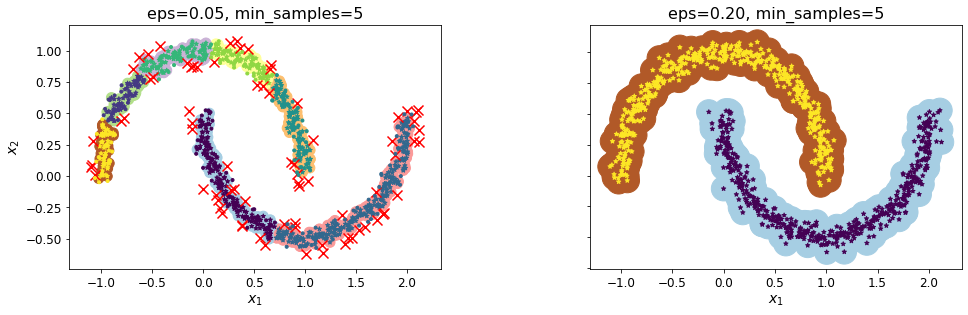

In [134]:
plt.figure(figsize=(16, 4.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(121)
plot_dbscan(dbscan, x, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, x, size=600, show_ylabels=False)

plt.show()

- `min_samples` primarily **controls how tolerant the algorithm is towards noise** (**on noisy and large data sets it may be desirable to increase this parameter**)


- `eps` is crucial to choose appropriately for the data set and distance function and usually cannot be left at the default value. It controls the local neighborhood of the points. When chosen too small, most data will not be clustered at all (and labeled as `-1` for “noise”). When chosen too large, it causes close clusters to be merged into one cluster, and eventually the entire data set to be returned as a single cluster. Some heuristics for choosing this parameter have been discussed in the literature, for example based on a knee in the nearest neighbor distances plot (as discussed in the references below).

**The `DBSCAN` class <font color='crimson'>does not</font> have a `predict()` method**, although it has a `fit_predict()` method. In other words, **<font color='crimson'>it cannot predict which cluster a new instance belongs to</font>**. This implementation decision was made **because** different classification algorithms can be better for different tasks, so the authors decided to let the user choose which one to use. Moreover, it’s not hard to implement.

In [135]:
from sklearn.neighbors import KNeighborsClassifier

In [136]:
knn = KNeighborsClassifier(n_neighbors=50)
# Notice: train only on the core instances
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

In [138]:
x_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(x_new)

array([1, 0, 1, 0])

In [139]:
knn.predict_proba(x_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

**we can choose how to train the model on the final task.**

- train the classifier on the core instances


- train the classifier on all the instances


- train the classifier on all the instances but the anomalies

**There is no anomaly in the training set, the classifier always chooses a cluster, even when that cluster is far away**. It is fairly straightforward to **introduce a maximum distance, in which case the two instances that are far away from both clusters are classified as anomalies**. 

To do this, use the `kneighbors()` method of the `KNeighborsClassifier`. Given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices, each with k columns):

In [142]:
y_dist, y_pred_idx = knn.kneighbors(x_new, n_neighbors=1)

In [143]:
y_dist

array([[0.43045422],
       [0.02225568],
       [0.06010476],
       [0.48399468]])

In [144]:
y_pred_idx

array([[909],
       [325],
       [915],
       [231]])

In [145]:
# because we only use the core samples to train the model
y_pred = dbscan2.labels_[dbscan2.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

In [148]:
# train on all the instances
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(x, dbscan2.labels_)

knn.predict_proba(x_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

In [150]:
# train on all the instances but the anomalies
knn = KNeighborsClassifier(n_neighbors=50)
all_labels = dbscan2.labels_
knn.fit(x[all_labels != -1], all_labels[all_labels != -1])

knn.predict_proba(x_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

- DBSCAN is a **very simple yet powerful** algorithm **capable of identifying any number of clusters of any shape**.


- DBSCAN is robust to outliers.


- DBSCAN has just two hyperparameters (`eps` and `min_samples`).


- If the density varies significantly across the clusters, however, DBCSAN can be impossible for it to capture all the clusters properly.


- DBSCAN's computational complexity is roughly $O(m log m)$, making it pretty close to linear with regard to the number of instances, but Scikit-Learn’s implementation can require up to $O(m2)$ memory if `eps` is large.